## How Smoothers Work

Don't confuse a kalman smoother for a low-pass filter type of smoothing.A kalman filter is an optimal fitler as it uses all the available information, a low-pass filter will be less accurate because it will remove important variations in the signal just as much as it removes noise.

- The Kalman Filter is a recursive filter with a Markov property, so all of its estimates are based on the previous estimate **k-1** and the current measurement **k**. So **k-1** has more influence than the **k-2** step and so on

- Smoothing filters incorporaste future measurements into the estimate for step **k**, and the measurement from **k+1** will have more influence than the **k+2** step and so on


## Types of Smoothers

- **Fixed-Interval Smoother**

    - Batch Filter
    - Useful when all data has been collected
    - Better results compared to the recursive filter when you have access to the complete data

- **Fixed-lag Smoothing**

    - Filter waits for a specific # of measurements before computing the estimate for the first filtered result, then continues this pattern for subsequent measurements. 
    - Introduces latency process- so useful when you're willing to trade output time for accuracy and smoothness. 
    
- **Fixed-Point Smooothing**

    - Works like a normal kalman filter until it reaches a specific point **j**, then the filter updates the estimate at X_j based on the measurements between j & k.
    - Used to estimate the initial parameters of a system,, for producing the best estimate for an event that happened at a specific time, or estimating pose information.

## RTS - A Fixed-Interval Smoother
- Invented by Rauch,Tung, and Stribel

The RTS filter works by running the filter directly normally, then the filter runs backwards taking into account the convariance matrices from the first pass to update the estimates - now with knowledge of future measurements - and come up the maximal optimal estimate.

### RTS - Algorithm Equation

    Predict Step
    
$$\begin{aligned}
\mathbf{P} &= \mathbf{FP}_k\mathbf{F}^\mathsf{T} + \mathbf{Q }
\end{aligned}$$

Basic predict multiplying the transition matrix with the state at K then mult times transpose of transition matrix then add noise

    Update Step
    
$$\begin{aligned}
\mathbf{K}_k &= \mathbf{P}_k\mathbf{F}^\mathsf{T}\mathbf{P}^{-1} \\
\mathbf{x}_k &= \mathbf{x}_k + \mathbf{K}_k(\mathbf{x}_{k+1} - \mathbf{Fx}_k) \\
\mathbf{P}_k &= \mathbf{P}_k + \mathbf{K}_k(\mathbf{P}_{k+1} - \mathbf{P})\mathbf{K}_k^\mathsf{T}
\end{aligned}$$

    - Calculate kalman gain
    - State @ k is equal to the state at k + the kalman gain multiplied by the residual of the state at k+1 and transition matrix times the current state. Its analogous to comparing a predicted estimate to a measurement then using the kalman gain to pick the optimal solution.
    - The prediction follows similar logic to updating the state, just multiplied by a kalman gain transpose.

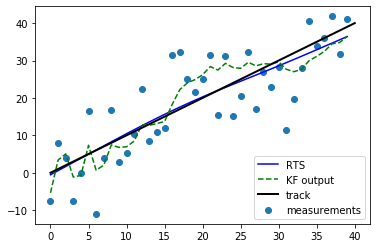

In [18]:
import numpy as np
from numpy import random
from numpy.random import randn
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

def plot_rts(noise, Q=0.001, show_velocity=False):
    random.seed(123)
    fk = KalmanFilter(dim_x=2, dim_z=1)

    fk.x = np.array([0., 1.])      # state (x and dx)

    fk.F = np.array([[1., 1.],
                     [0., 1.]])    # state transition matrix

    fk.H = np.array([[1., 0.]])    # Measurement function
    fk.P = 10.                     # covariance matrix
    fk.R = noise                   # state uncertainty
    fk.Q = Q                       # process uncertainty

    # create noisy data
    zs = np.asarray([t + randn()*noise for t in range (40)])

    # filter data with Kalman filter, than run smoother on it
    mu, cov, _, _ = fk.batch_filter(zs)
    M, P, C, _ = fk.rts_smoother(mu, cov)

    # plot data
    if show_velocity:
        index = 1
        print('gu')
    else:
        index = 0
    points = [x for x in range(len(zs)) ]
    plt.scatter(points,zs,label='measurements')
    
    plt.plot(M[:, index], c='b', label='RTS')
    plt.plot(mu[:, index], c='g', ls='--', label='KF output')
    if not show_velocity:
        N = len(zs)
        plt.plot([0, N], [0, N], 'k', lw=2, label='track') 
    plt.legend(loc=4)
    plt.show()
    
plot_rts(7.)

First run kalman filter on measurements, then use the mean and covariance values to run the RTS filter.

The RTS is still taking the transition matrix into consideration, meaning it expects the system to behave linearly. If whatthe filter is attempting to measure does not behave this way, it will try to optimize to what the kF is estimating and the measurements. Meaning that the process model still needs to be correct or the filter will perform poorly

In [ ]:
##